# Analysis presented in plots
Here we create the plots that allow us to do the analysis of the results. For each distribution that we present in the figures we calculate the KS two-samples statistics to have a numerical value on how different they really are (The value is the distance between the [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the samples).

We import all the packages necessary to plot the results from the models

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools
import pandas as pd
import seaborn as sns
import astropy.units as u
from collections import Counter
from scipy.stats import ks_2samp
import matplotlib.lines as mlines
from astropy.modeling import models
from astroquery.simbad import Simbad
from scipy.stats import binned_statistic
from astropy.table import Table, join, hstack

Additionally, we add some shortcuts

In [3]:
# User shortcuts
def Perc75(array):
    """75th Percentile"""
    return(np.percentile(array, 75))


def Perc25(array):
    """25th Percentile"""
    return(np.percentile(array, 25))

## Join all clean results

We read the clean results from the models we are going to use 

In [4]:
ModelS = Table.read('CIGALEOutputs/Cleanresults_SK.fits', format='fits')
ModelF = Table.read('CIGALEOutputs/Cleanresults_Fr.fits', format='fits')

ModelS37 = Table.read('CIGALEOutputs/Cleanresults_SK37.fits', format='fits')
ModelF37 = Table.read('CIGALEOutputs/Cleanresults_Fr37.fits', format='fits')

We also read the original database of galaxies to use the information for the classification

In [5]:
TV = Table.read('VCV_TAP_otype.txt', format='ascii')
TV.rename_column('main_id', 'id')  # Renamed to use the join with the same id

We select a list of parameters from the models to be plotted (Check also the Analysis_Tables file to check why we choose these parameters). We add the errors from these parameters also in the plots. Also, we define quantities useful for plots for each parameters.

In [6]:
ParamCheck = ['bayes.agn.i', 'bayes.agn.fracAGN', 'bayes.agn.disk_luminosity', 'bayes.agn.EBV',
              'bayes.attenuation.E_BVs', 'bayes.sfh.tau_main', 'bayes.sfh.sfr']
ParamUnit = ['[degrees]', 'Fraction', 'log([L$_{\odot}$])', 'mag',
             'mag', r'log([Myr])', r'log([M$_{\odot}$/yr])']
ParamLabel = ['View. Angle', r'$f_{\rm{AGN}}$', r'$\rm{L}_{\rm{AGN}}^{\rm{disk}}$',
              r'Polar-dust E(B-V)', 'E(B-V)', r'$\tau_{\rm{main}}$', 'SFR']
ParamRange = [[0, 90], [0.05, 0.95], [7, 13], [0, 1],
              [0, 0.4], [1.5, 4], [-3, 3]]
ParamCheckErr = [j+'_err' for j in ParamCheck]
ParamRangeErr = [[0, 40], [0.0, 0.4], [0, 1],
                 [0, 0.5], [0, 0.15], [0, 0.8], [0, 1]]
ParamUnitErr = ['[degrees]', 'Fraction', 'dex', 'mag', 'mag', 'dex', 'dex']
Particks = [[0,25,45,65,90],[0.25,0.5,0.75],[8,10,12],[0,0.4,0.8],
           [0,0.2,0.4],[2,3,4],[-2,0,2]]
ParticksErr = [[0,10,20,30],[0,0.1,0.2,0.3],[0.25,0.5,0.75],[0,0.2,0.4],[0,0.05,0.1],
           [0,0.2,0.4,0.6],[0,0.5,1]]

We join these clean tables with the catalog. We send all the tables to pandas format. Then, we concatenate the tables to have an unique table.

In [7]:
SPandas = join(TV, ModelS, keys='id').to_pandas()
FPandas = join(TV, ModelF, keys='id').to_pandas()
SPandas37 = join(TV, ModelS37, keys='id').to_pandas()
FPandas37 = join(TV, ModelF37, keys='id').to_pandas()
SFPandas = pd.concat([SPandas, FPandas, SPandas37, FPandas37], 
                     keys=['SKIRTOR', 'Fritz', 'S37', 'F37'], names=['Model', 'idCIG'])

We transform luminosities from W to solar luminosities. We reformat some parameters in log units, useful for the plots.

In [8]:
for kisd in ['bayes.agn.luminosity', 'bayes.agn.disk_luminosity', 
             'bayes.agn.dust_luminosity','bayes.dust.luminosity']:
    SFPandas[kisd] = (SFPandas[kisd].values*u.W).to(u.solLum).value
    SFPandas[kisd+'_err'] = (SFPandas[kisd+'_err'].values *u.W).to(u.solLum).value

for asdf in ['bayes.agn.disk_luminosity', 'bayes.sfh.sfr', 'bayes.sfh.tau_main']:
    SFPandas[asdf+'_err'] = SFPandas[asdf+'_err']/(SFPandas[asdf] * log(10))
    SFPandas[asdf] = log10(SFPandas[asdf])

Finally, we create two functions that will help us to plot all the comparisons in the same way and visualize the results from the KS statistics. 

In [9]:
def ParamFigure(PandaTable, HueMod, Method='scott', Order=None):
    """Figure used to present the results and comparisons for the selected parameters"""
    ii = 0
    LineSty = ['-', '--', ':']
    for iP, Parm in enumerate(ParamCheck):
        ii += 1
        subplot2grid((2, len(ParamCheck)), (0, ii-1))
        if len(HueMod) > 1:
            for KL in range(len(HueMod[1])):
                sns.kdeplot(data=PandaTable.loc[[HueMod[1][KL]]], x=Parm, hue=HueMod[0],
                            legend=False, hue_order=Order, clip=ParamRange[iP], bw_method=Method,
                            common_norm=False, ls=LineSty[KL])
            if ii > 1:
                plt.yticks([])
                plt.ylabel(None)
        else:
            sns.kdeplot(data=PandaTable, x=Parm, hue=HueMod[0], legend=False, hue_order=Order,
                        clip=ParamRange[iP], bw_method=Method, common_norm=False)
            if ii > 1:
                plt.yticks([])
                plt.ylabel(None)
        title(ParamLabel[ii-1], fontsize=12)
        xlabel(ParamUnit[ii-1])
        xlim(ParamRange[iP])
        xticks(Particks[iP])
    ii = 0
    for iP, Parm in enumerate(ParamCheckErr):
        ii += 1
        subplot2grid((2, len(ParamCheckErr)), (1, ii-1))
        if len(HueMod) > 1:
            for KL in range(len(HueMod[1])):
                sns.kdeplot(data=PandaTable.loc[[HueMod[1][KL]]], x=Parm, hue=HueMod[0],
                            legend=False, hue_order=Order, clip=ParamRangeErr[iP], 
                            bw_method=Method, common_norm=False, ls=LineSty[KL])
            if ii > 1:
                plt.yticks([])
                plt.ylabel(None)
        else:
            sns.kdeplot(data=PandaTable, x=Parm, hue=HueMod[0], legend=False, hue_order=Order,
                        clip=ParamRangeErr[iP], bw_method=Method, common_norm=False)
            if ii > 1:
                plt.yticks([])
                plt.ylabel(None)
        xlabel(ParamUnitErr[ii-1])
        xlim(ParamRangeErr[iP])
        xticks(ParticksErr[iP])
    subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0)

def MatrixKS(PandaTable, HueMod):
    """Create a Matrix for the Pandas Tables with  he KS statistic and plot it."""
    fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = subplots(2,4, figsize=(16,8))
    axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    for iP, Parm in enumerate(ParamCheck):
        if len(HueMod)== 1:
            Matr = np.empty(16)*np.nan
            iterables = [ HueMod[0], HueMod[0] ]
            for it,t in enumerate(itertools.product(*iterables)):
                Matr[it]=ks_2samp(PandaTable.loc[[t[0]]][Parm],
                                  PandaTable.loc[[t[1]]][Parm])[0]
        if len(HueMod)>1:
            Matr = np.empty(len(HueMod[1])**2)*np.nan
            iterables = [ HueMod[1], HueMod[1] ]
            for it,t in enumerate(itertools.product(*iterables)):
                T0=t[0].split(' ')
                T1=t[1].split(' ')
                Matr[it]=ks_2samp(PandaTable.loc[T0[0]][PandaTable.loc[T0[0]][HueMod[0]] == T0[1]][Parm],
                                  PandaTable.loc[T1[0]][PandaTable.loc[T1[0]][HueMod[0]] == T1[1]][Parm])[0]
        Ms=axs[iP].imshow(Matr.reshape(len(iterables[0]),len(iterables[0])),cmap='RdBu')
        axs[iP].set_title(Parm)
        axs[iP].tick_params(axis='y', rotation=45)
        axs[iP].tick_params(axis='x', rotation=45)
        plt.colorbar(Ms,ax=axs[iP],fraction=0.046, pad=0.04)
    ax8.set_visible(False)
    plt.setp(axs, xticks=np.arange(len(iterables[0])), xticklabels=iterables[0],
             yticks=np.arange(len(iterables[0])), yticklabels=iterables[0])
    plt.subplots_adjust(wspace=0.6,hspace=0.05)

## Compare physical parameters between Fritz and SKIRTOR
##### FIGURE 4
We plot the density distribution of the parameters and the models used in this work, together with the density distributions of the errors derived by CIGALE. 

In [10]:
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    figure(figsize=(14.06, 3.77))
    ParamFigure(SFPandas, ['Model'])
    SKI = mlines.Line2D([], [], color='C0', label='SKIRTOR')
    Fri = mlines.Line2D([], [], color='C1', label='Fritz')
    S37 = mlines.Line2D([], [], color='C2', label='SK-30/70')
    F37 = mlines.Line2D([], [], color='C3', label='Fr-30/70')
    plt.legend(handles=[SKI, Fri, S37, F37], loc='upper right', fontsize=8)
    subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                    right=0.9, hspace=0.6, wspace=0)
    savefig('Figures/F4.pdf', dpi=300, bbox_inches='tight')  # For Paper
#     savefig('Talk_Figures/F4.png',dpi=300,bbox_inches = 'tight') ## For Presentation

##### KS numerical values
We present the KS test statistics here 

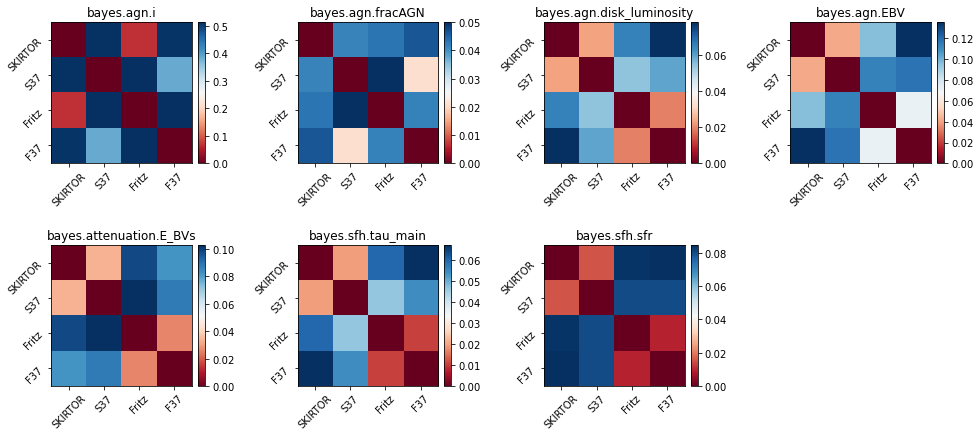

In [11]:
%matplotlib inline
MatrixKS(SFPandas,[['SKIRTOR', 'S37', 'Fritz', 'F37']])

## Compare physical parameters with Seyfert type
##### FIGURE 5
We plot the density distribution of the parameters but this time separating Seyfert type classification. 

In [12]:
%matplotlib
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    figure(figsize=(14.06, 3.77))
    Selc5_1 = np.logical_or(np.logical_and(SFPandas['otype_txt'] == 'Sy1',
                                           SFPandas['Sp'] == 'S1'),
                            np.logical_and(SFPandas['otype_txt'] == 'Sy1',
                                           SFPandas['Sp'] == 'S1n'))
    Selc5_2 = np.logical_and(SFPandas['otype_txt'] == 'Sy2',
                             SFPandas['Sp'] == 'S2')
    Selc5 = np.logical_or(Selc5_1, Selc5_2)
    ParamFigure(SFPandas[Selc5], ['otype_txt', ['SKIRTOR', 'Fritz']])
    S1Cl = mlines.Line2D([], [], color='C0', label='S1_SK')
    S2Cl = mlines.Line2D([], [], color='C1', label='S2_SK')
    S1Sm = mlines.Line2D([], [], color='C0', label='S1_Fr', ls='--')
    S2Sm = mlines.Line2D([], [], color='C1', label='S2_Fr', ls='--')
    plt.legend(handles=[S1Cl, S2Cl, S1Sm, S2Sm], loc='upper right', fontsize=8)
    subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                    right=0.9, hspace=0.6, wspace=0)
    savefig('Figures/F5.pdf',dpi=300,bbox_inches = 'tight')
#     savefig('Talk_Figures/F5.png', dpi=300, bbox_inches='tight')  # For Presentation

Using matplotlib backend: Qt5Agg


##### KS numerical values
We present the KS test statistics here 

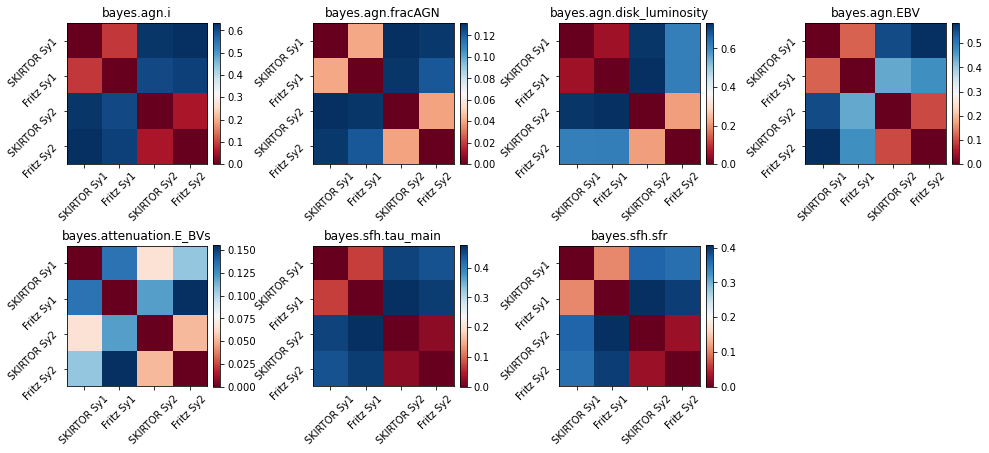

In [13]:
%matplotlib inline
MatrixKS(SFPandas[Selc5], ['otype_txt', ['SKIRTOR Sy1','Fritz Sy1','SKIRTOR Sy2','Fritz Sy2']])

We include an alternative version to this plot for the 30/70 cases

In [14]:
%matplotlib
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    figure(figsize=(14.06, 3.77))
    ParamFigure(SFPandas[Selc5], ['otype_txt', ['S37', 'F37']])
    S1Cl = mlines.Line2D([], [], color='C0', label='S1_SK_30/70')
    S2Cl = mlines.Line2D([], [], color='C1', label='S2_SK_30/70')
    S1Sm = mlines.Line2D([], [], color='C0', label='S1_Fr_30/70', ls='--')
    S2Sm = mlines.Line2D([], [], color='C1', label='S2_Fr_30/70', ls='--')
    plt.legend(handles=[S1Cl, S2Cl, S1Sm, S2Sm], loc='upper right', fontsize=8)
    subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                    right=0.9, hspace=0.6, wspace=0)
    savefig('Figures/F5_Alt.pdf', dpi=300, bbox_inches='tight')
#     savefig('Talk_Figures/F5_Alt.png', dpi=300, bbox_inches = 'tight') ## For Presentation

Using matplotlib backend: Qt5Agg


##### KS numerical values
We present the KS test statistics here 

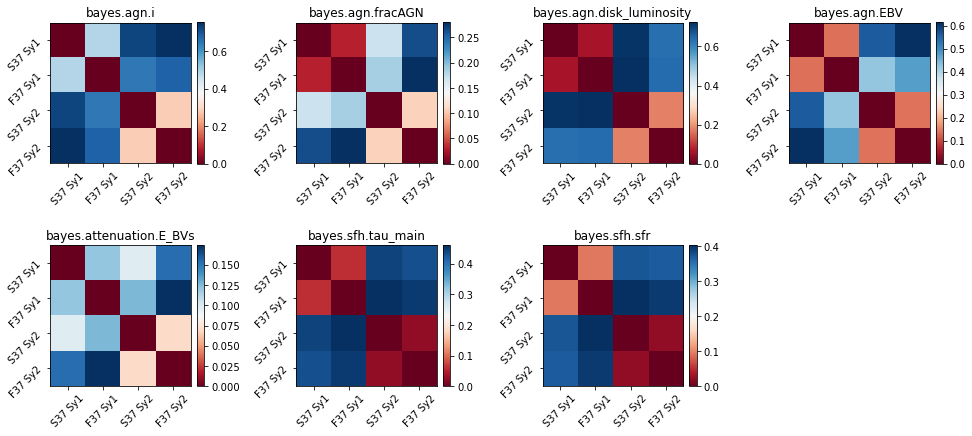

In [15]:
%matplotlib inline
MatrixKS(SFPandas[Selc5], ['otype_txt', ['S37 Sy1','F37 Sy1','S37 Sy2','F37 Sy2']])

## Compare VCV intermediate classifications
##### FIGURE 6
We plot the VCV-Osterbrock classification of Seyfert galaxies in the same way as before. (Only with SKIRTOR results) 

In [16]:
Selc7 = np.logical_or.reduce([SFPandas['Sp'] == 'S1.0', SFPandas['Sp'] == 'S1.2', 
                              SFPandas['Sp'] == 'S1.5', SFPandas['Sp'] == 'S1.8', 
                              SFPandas['Sp'] == 'S1.9'])

In [17]:
%matplotlib
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    figure(figsize=(14.06, 3.77))
    ParamFigure(SFPandas[Selc7], ['Sp', ['SKIRTOR']], 
                Order=['S1.0', 'S1.2', 'S1.5', 'S1.8', 'S1.9'])
    O1 = mlines.Line2D([], [], color='C0', label='S1.0')
    O2 = mlines.Line2D([], [], color='C1', label='S1.2')
    O3 = mlines.Line2D([], [], color='C2', label='S1.5')
    O4 = mlines.Line2D([], [], color='C3', label='S1.8')
    O5 = mlines.Line2D([], [], color='C4', label='S1.9')
    plt.legend(handles=[O1, O2, O3, O4, O5], loc='upper right', fontsize=8)
    subplots_adjust(top=0.9, bottom=0.1, left=0.1,
                    right=0.9, hspace=0.6, wspace=0)
    savefig('Figures/F6.pdf', dpi=300, bbox_inches='tight')
#     savefig('Talk_Figures/F6.png', dpi=300, bbox_inches = 'tight') ## For Presentation

Using matplotlib backend: Qt5Agg


##### KS numerical values
We present the KS test statistics here 

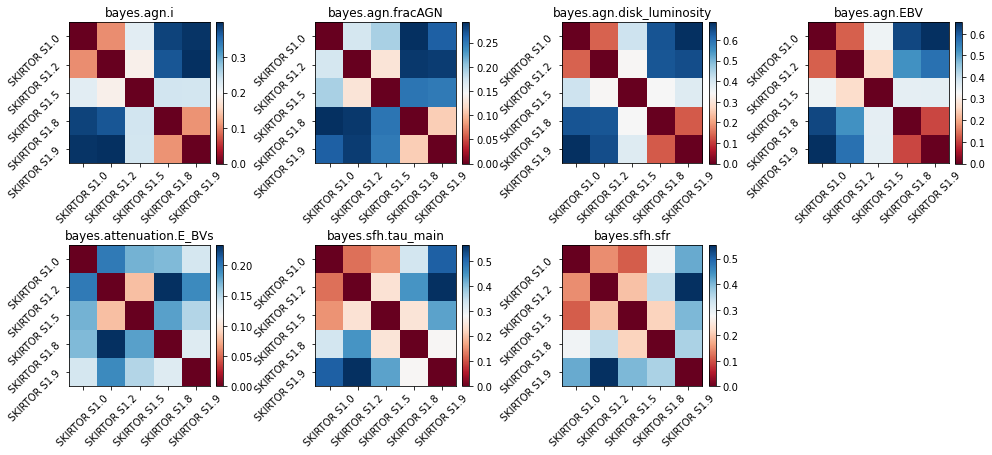

In [18]:
%matplotlib inline
MatrixKS(SFPandas[Selc7], ['Sp', ['SKIRTOR S1.0','SKIRTOR S1.2','SKIRTOR S1.5','SKIRTOR S1.8', 'SKIRTOR S1.9']])

## Redshift evolution of physical parameters
##### FIGURE 7
We now center on how the physical parameters in Seyferts change with redshift. We calculate the running/moving median for the parameters in terms of redshift. We only use the estimations coming from the SKIRTOR model in galaxies with z<1= as only a few galaxies are above this limit. 
The number of galaxies we are missing in the plots with this last restriction are:

In [19]:
sum(SPandas['rvz_redshift']>=1.01)

22

We define a class to plot an analyze the evolution of the parameters with redshift.

In [20]:
class RedshiftEvol:
    """Class to examine the redshift evolution of the parameters in CIGALE"""
    def __init__(self,Data, Parameters, binsz, minpoints):
        self.data = Data
        self.param = Parameters
        self.minpoint = minpoints
        self.binsz = binsz
        self.PlotRedshiftEvol()
    

    def PrintDiff(self, Diff, Paramet):
        """Function to print the minimun an  maximun difference between the Seyfert types with 
        the location in terms of redshift."""
        Mind = np.nanmin(Diff)
        Maxd = np.nanmax(Diff)
        WMin = np.where(Diff == Mind)[0]
        WMax = np.where(Diff == Maxd)[0]
        print('For %s the minimum difference (%.2f) is at z=%.2f\n \
               \t while the maximum difference (%.2f) is at z=%.2f' % (Paramet,
                                                                       Mind, self.binsz[WMin],
                                                                       Maxd, self.binsz[WMax]))


    def PlotRedshiftEvol(self):
        """Calculate the moving median for each parameter in terms of Seyfert 1 and Seyfert 2 
        with a confidence interval between the 25th and 75th percentiles. For AGN disk 
        luminosity and viewing angle we plot the criteria to separate the two samples."""
        fig, ax = plt.subplots(len(self.param)+1, 1,
                               figsize=(6.75, 14.44), sharex=True)
        DictLimsScatter = {'Sy1': 0.8, 'Sy2': 0.625}
        for iPar, ParaY in enumerate(self.param):
            ComparType = []
            for STypes in ['Sy1', 'Sy2']:
                Subset = self.data['otype_txt'] == STypes
                if iPar == 0:
                    ax[iPar].hist(self.data['rvz_redshift'][Subset], histtype='step',
                                  bins=self.binsz, label=STypes, lw=2)
                Medians = []
                for Sta in ['median', Perc75, Perc25]:
                    Medians.append(binned_statistic(self.data['rvz_redshift'][Subset],
                                                    self.data[ParaY][Subset],
                                                    statistic=Sta, bins=self.binsz)[0])
                GoodSy = histogram(self.data['rvz_redshift'][Subset],
                                   bins=self.binsz)[0] >= self.minpoint
                Scat = np.logical_and(Subset,
                                      self.data['rvz_redshift'] >= DictLimsScatter[STypes])
                p = ax[iPar+1].plot(self.binsz[:-1][GoodSy], Medians[0][GoodSy],
                                    label=r'Param'+STypes)
                ax[iPar+1].fill_between(self.binsz[:-1][GoodSy], Medians[1][GoodSy],
                                        y2=Medians[2][GoodSy], alpha=0.2)
                color = p[0].get_color()
                ax[iPar+1].scatter(self.data['rvz_redshift'][Subset][Scat],
                                   self.data[ParaY][Subset][Scat], c=color, alpha=0.2)
                if iPar == 3:
                    ax[iPar+1].set_ylabel('Polar-dust')
                else:
                    ax[iPar+1].set_ylabel(ParamLabel[iPar])
                ComparType.append(Medians[0])
            Diffarray = np.ptp(ComparType, axis=0)[GoodSy]
            if ParaY == 'bayes.agn.i':
                ax[iPar+1].plot(self.binsz[:-1], 
                                np.ones(len(self.binsz[:-1]))*45,  ls='--')
            if ParaY == 'bayes.agn.disk_luminosity':
                z = np.polyfit(self.binsz[:-1],
                               np.nanmean(ComparType, axis=0), 2, w=GoodSy)
                p = np.poly1d(z)
                print(p,': Polyfit to AGN disk luminosity with x being the redshift')
                ax[iPar+1].plot(self.binsz[:-1][GoodSy], p(self.binsz[:-1][GoodSy]), ls='--')
                CondinLim = self.binsz[:-1] >= DictLimsScatter['Sy2']
                ax[iPar+1].plot(self.binsz[:-1][CondinLim],
                                p(np.ones(len(self.binsz[:-1]))*0.6)[CondinLim], ls=':', C='C2')
            self.PrintDiff(Diffarray, ParamLabel[iPar])
            ax[iPar+1].set_xlim(-0.01, 1.01)
            ax[iPar+1].set_ylim(ParamRange[iPar])
            if iPar == 4:
                ax[iPar+1].set_yticks([0.1, 0.2, 0.3])
            else:
                ax[iPar+1].set_yticks(Particks[iPar])
        ax[0].set_ylabel('# Gal.')
        ax[0].set_xlim(-0.01, 1.01)
        ax[0].legend(loc='best')
        ax[0].set_yticks([150, 300, 450])
        ax[-1].set_xlabel(r'$\rm{Redshift}$')
        subplots_adjust(wspace=0, hspace=0)

Finally, we plot the results. We limited the number a galaxies in a bin to a minimum of 6 galaxies. After that we plot the galaxies as scatter plots. 

In [25]:
%matplotlib
# Values of redshifts to bin the data
RzBins = np.linspace(0.0, 1.0, 41)# or 21,31
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    RedshiftEvol(SFPandas.loc['SKIRTOR'], ParamCheck, RzBins, 6)
    savefig('Figures/F7.pdf',dpi=300,bbox_inches = 'tight')
#     savefig('Talk_Figures/F7.png',dpi=300,bbox_inches = 'tight') ## For Presentation

Using matplotlib backend: Qt5Agg
For View. Angle the minimum difference (20.25) is at z=0.38
                	 while the maximum difference (60.32) is at z=0.43
For $f_{\rm{AGN}}$ the minimum difference (0.00) is at z=0.33
                	 while the maximum difference (0.25) is at z=0.45
       2
-5.37 x + 6.359 x + 8.936 : Polyfit to AGN disk luminosity with x being the redshift
For $\rm{L}_{\rm{AGN}}^{\rm{disk}}$ the minimum difference (0.81) is at z=0.00
                	 while the maximum difference (2.12) is at z=0.43
For Polar-dust E(B-V) the minimum difference (0.09) is at z=0.08
                	 while the maximum difference (0.42) is at z=0.50
For E(B-V) the minimum difference (0.00) is at z=0.15
                	 while the maximum difference (0.08) is at z=0.50
For $\tau_{\rm{main}}$ the minimum difference (0.00) is at z=0.53
                	 while the maximum difference (0.75) is at z=0.15
For SFR the minimum difference (0.04) is at z=0.33
                	 while the maxim

Finally we check how much representative is the contribution of the disk AGN luminosity to the total AGN luminosity

In [22]:
def ContributionDiskLum(Data):
    for STypes in ['Sy1', 'Sy2']:
        Subset = Data[Data['otype_txt'] == STypes]
        Contrib = 10**Subset['bayes.agn.disk_luminosity'] / Subset['bayes.agn.luminosity']
        print('For %s the median contribution of AGN disk luminosity is %.2f\n \
            \t with a minimum of %.3f and a maximum of %.3f' % (STypes, np.median(Contrib),
                                                                np.min(Contrib),
                                                                np.max(Contrib)))
        Contrib = Subset['bayes.agn.dust_luminosity'] / Subset['bayes.agn.luminosity']
        print('For %s the median contribution of AGN dust luminosity is %.2f\n \
            \t with a minimum of %.3f and a maximum of %.3f' % (STypes, np.median(Contrib),
                                                                np.min(Contrib),
                                                                np.max(Contrib)))

In [23]:
ContributionDiskLum(SFPandas.loc['SKIRTOR'])

For Sy1 the median contribution of AGN disk luminosity is 0.50
             	 with a minimum of 0.001 and a maximum of 0.815
For Sy1 the median contribution of AGN dust luminosity is 0.50
             	 with a minimum of 0.185 and a maximum of 0.999
For Sy2 the median contribution of AGN disk luminosity is 0.04
             	 with a minimum of 0.001 and a maximum of 0.807
For Sy2 the median contribution of AGN dust luminosity is 0.96
             	 with a minimum of 0.193 and a maximum of 0.999


##### Notebook info

In [24]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
numpy     : 1.19.5
seaborn   : 0.11.1
astropy   : 4.2
json      : 2.0.9
re        : 2.2.1
pandas    : 1.2.0
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
matplotlib: 3.2.2
autopep8  : 1.5.4
logging   : 0.5.1.2

Watermark: 2.1.0

